# U-Net propuesto

El dataset preprocesado fue obtenido de [this pre-processed TuSimple](https://www.kaggle.com/datasets/hikmatullahmohammadi/tusimple-dataset-preprocessed).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

In [ ]:
# ubicación de dataset de entrenamiento
train_path = '/kaggle/input/dataset/kaggle/working/tusimple_preprocessed/training'

In [ ]:
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

No existe clases asociadas a las imágenes. Hay dos carpetas, uno para imágenes y otro para sus máscaras de los carriles correspondientes a cada imagen.

In [ ]:
num_images = 7252 
num_batches = num_images // 64 + 1

X = [] #lista de imágenes
Y = [] #lista de máscaras en escala de grises

for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0]
    batch_labels = batch[1]
    for ind, lb in enumerate(batch_labels):
        if lb == 0: 
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y es de forma (None, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
# realizamos un shuffle al dataset inicial
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

# Modeling

In [ ]:
# Normalizar y redimensionar las máscaras
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [ ]:
Y.min(), Y.max()
#Los valores posibles de Y son 1 que indica que la imagen almacenada en X tiene una máscara, mientras que 0 significa lo contrario.

In [ ]:
# del dataset inicial solo se toma 2000 muestras para el entrenamiento
X = np.array(X[:2000])
Y = np.array(Y[:2000])

In [ ]:
# Se asigna 1800 en imágenes para entrenamiento, y 200 para la validación
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)

In [ ]:
print("Shape de X_train:", X_train.shape)
print("Shape de X_val:", X_val.shape)
print("Shape de Y_train:", Y_train.shape)
print("Shape de Y_val:", Y_val.shape)

In [ ]:
# liberar la RAM de los clutters no deseados usando un garbage collector
import gc
del X, Y, images_set
gc.collect()

In [ ]:
#algunas imágenes con sus respectivas máscaras del los datos de entrenamiento
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def unet(input_size=(256,320,3)):
    inputs = Input(input_size)
    rescale = keras.layers.Rescaling(1./255)(inputs)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    drop4 = Dropout(0.5)(conv4)
    
    # Decoder
    up5 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop4))
    merge5 = Concatenate(axis=3)([conv3, up5])
    
    up6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(merge5))
    merge6 = Concatenate(axis=3)([conv2, up6])
    
    up7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(merge6))
    merge7 = Concatenate(axis=3)([conv1, up7])
    
    outputs = Conv2D(1, 1, activation='sigmoid')(merge7)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = unet()


In [ ]:
# Compilamos el modelo con el optimizador Adam
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()

In [ ]:
#Entrenar el modelo
epochs = 15
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
log = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)

In [ ]:
plt.figure()
plt.title("Loss x epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# la evolución del accuracy durante el entrenamiento
plt.figure()
plt.title("Accuracy x Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(log.history['accuracy'], label='train')
plt.plot(log.history['val_accuracy'], label='validation')
plt.legend()
plt.show()


In [ ]:
preds = model.predict(X_val)
preds.max(), preds.min()

In [ ]:
# directorio de salida
!mkdir out

In [ ]:
# Imagen de validación vs máscara predicha vs máscara real
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):
    
    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)
    
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [ ]:
# guardar modelo
model.save('/kaggle/working/lane-detection-model')

In [ ]:
# Métricas
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precisión
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# IoU
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recal:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

---

Prueba del modelo con una imagen que no pertence al dataset inicial

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ruta a la imagen
image_path = '/kaggle/input/javierprado/javierPrado.jpg'  # Reemplaza con la ruta una imagen

# Cargar la imagen
img = keras.preprocessing.image.load_img(image_path, target_size=(256, 320))  # Ajusta el tamaño

# Convertir la imagen en un array numpy
img_array = keras.preprocessing.image.img_to_array(img)

# Expandir las dimensiones para que sea compatible con ImageDataGenerator
img_array = np.expand_dims(img_array, axis=0)

In [ ]:
preds = model.predict(img_array)
preds.max(), preds.min()

In [ ]:
#Resultados, imagénes vs. Máscara predicha
plt.figure(figsize=(10, 45))
s, e = 0, 1
index = 1

preds = (preds >= .5).astype('int')
for i, j in zip(img_array, preds[s:e]):
    
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    
    
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

# Modelo guardado

Se define un array de imágenes de prueba

In [2]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir el directorio que contiene las imágenes
directory = '/kaggle/input/datatest/kaggle/working'

img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
generator = img_generator.flow_from_directory(
    directory,
    shuffle=False,
    batch_size=1,
    class_mode=None,
    target_size=(256, 320)
)
num_images = len(generator.filenames)
all_images_test = np.zeros((num_images, 256, 320, 3), dtype=np.float32)

# Iterar sobre el generador y acumular las imágenes en el array
for i in range(num_images-1):
    img_batch = next(generator)
    all_images_test[i] = img_batch[0]  

Found 5 images belonging to 1 classes.


Usar el modelo guardado

In [3]:
#cargar el modelo entrenado
import tensorflow as tf
from tensorflow import keras
# Cargar el modelo
model = tf.keras.models.load_model('/kaggle/working/lane-detection-model')
preds = model.predict(all_images_test)
preds.max(), preds.min()



1/1 [==============================] - 3s 3s/step


(0.8577859, 4.3669868e-34)

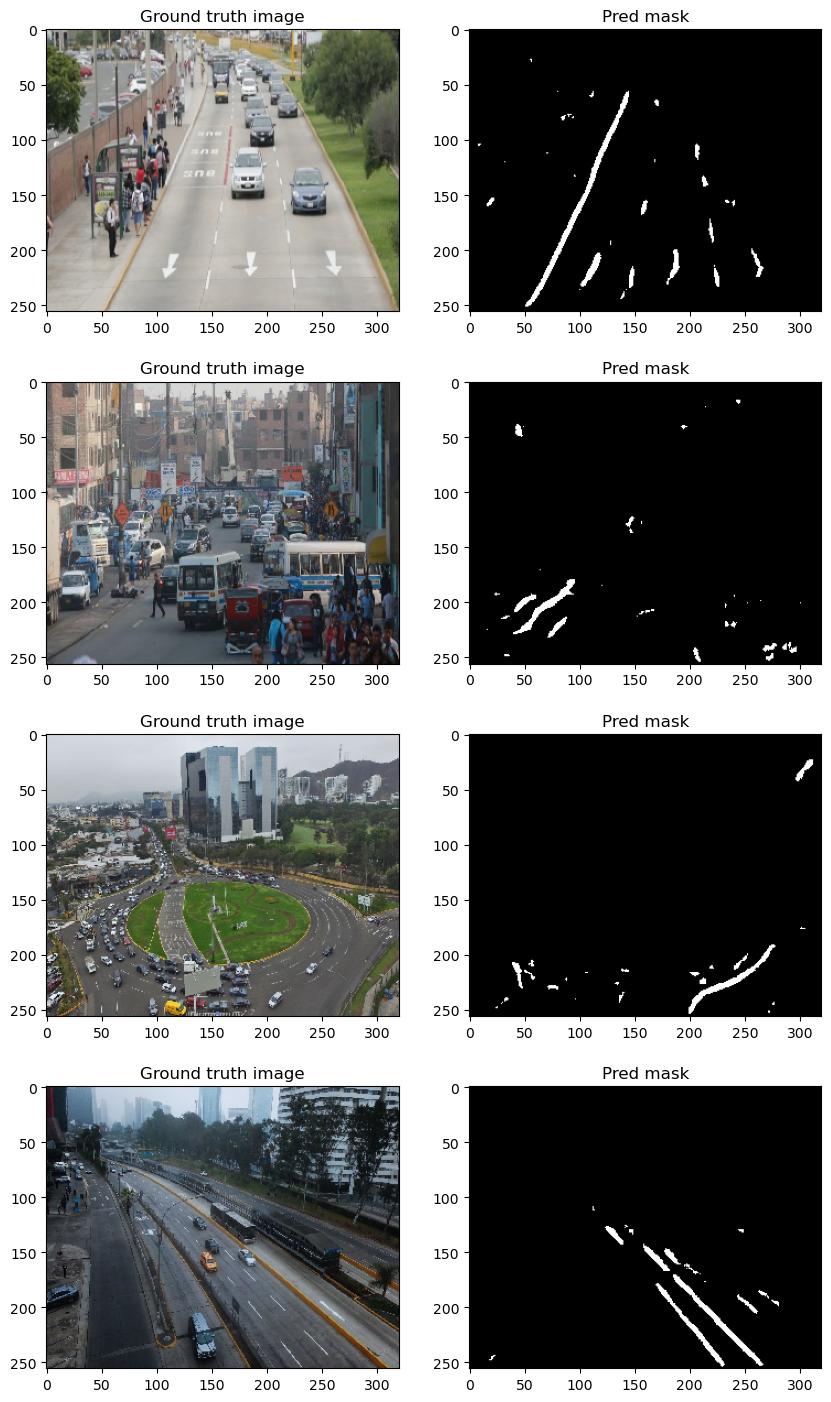

In [6]:
# Imagen de prueba vs máscara predicha
plt.figure(figsize=(10, 45))
s, e = 0, 4
index = 1

preds = (preds >= .5).astype('int')
for i, j in zip(all_images_test, preds[s:e]):
    
    
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    
    
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2